In [ ]:
### First we have downloaded a net CDF from the Copernicus Data Store: https://cds.climate.copernicus.eu

In [ ]:
file = '/Users/gbenz/Downloads/tx10pETCCDI_mon_HadGEM3-GC31-LL_historical_r1i1p1f3_b1981-2010_v20190624_185001-201412_v2-0.nc'

In [1]:
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
import numpy as np

from utils.unzip import unzip_etccdi_package
from utils.correct_longitude import transform_longitudinal_values
from utils.give_metadata import give_metadata
from utils.etccdi_to_pg import generate_etccdi_temporal_tables
from utils.temporal_index import find_etccdi_timeindex
from utils.define_request import generate_and_validate_request

## Access with Copernicus Data Store API:

#### Objective by Oct. 30 is to have this process begin by retreiving (predefined and approved) ETCCDI data parameters from an API

- Works on Mon 28 GB

The proceeding code provides a correct output but requires a unique user API key. This cannot be simplified much further.

The desirable output is to exclusively change:
- 'variable' 
- product_type
- period
#### ------------------
- start_year = '1995'
- start_month = '01'
- end_year = '2000'
- end_month = '12'

Then if you select 'cold days' a decision tree will be printed with the optional parameters that could be selected for product type and period
Other parameters will be kept standard. 

In [11]:


# Now, calling the function will generate and validate the request
request = generate_and_validate_request(
    variable="consecutive_wet_days",
    product_type="base_independent",
    experiment="historical",
    temporal_aggregation="yearly"
)

display(request)


Request is valid.


{'variable': ['consecutive_wet_days'],
 'product_type': ['base_independent'],
 'model': ['hadgem3_gc31_ll'],
 'ensemble_member': ['r1i1p1f3'],
 'experiment': ['historical'],
 'temporal_aggregation': ['yearly'],
 'period': ['1850_2014'],
 'version': ['2_0'],
 'data_format': 'netcdf'}

In [12]:
import cdsapi

dataset = "sis-extreme-indices-cmip6"

# Extract the desired elements from the request dictionary
variable = request["variable"][0]
temporal_aggregation = request["temporal_aggregation"][0]
period = request["period"][0]

# Concatenate them with an underscore or any other separator you prefer
zip_file_name = f"{variable}_{temporal_aggregation}_{period}.zip"

client = cdsapi.Client()
client.retrieve(dataset, request, target=zip_file_name)


2024-11-11 17:17:27,289 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-11 17:17:27,289 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-11 17:17:27,289 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-11 17:17:27,290 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

c2c4efa8cddb850c255ac55774f4ec0f.zip:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

'consecutive_wet_days_yearly_1850_2014.zip'

In [13]:
netcdf_file, etccdi_index = unzip_etccdi_package(zip_file_name)

cwdETCCDI
Extracted file names: cwdETCCDI_yr_HadGEM3-GC31-LL_historical_r1i1p1f3_no-base_v20190624_1850-2014_v2-0.nc


### Report Metadata from the selected ETTCDI netCDF file:

Move the pg shapefile to the github repo so this can be accessed without references to local paths

Accomplishes:
- checks to ensure the correct netcdf file is being processed
- provides spatial and temporal metadata

From preprocessing, we know that the ETCCDI climate data is not packaged in a desirable format, that is, the original longitudinal range is: 0.9375 to 359.0625
- Adjust the Longitude range 
- save an 'adjusted netcdf' file.


28-10 -- What would perhaps be most desirable is to first transform, then, report metadata with two seperate functions.

In [14]:
etccdi = transform_longitudinal_values(etccdi_index, netcdf_file)

The variable 'cwdETCCDI' was found in the file path and the world continues to spin.
Original Latitude range: -89.375 to 89.375
Original Longitude range: 0.9375 to 359.0625
Adjusted Longitude range: -179.0625 to 179.0625
Adjusted dataset saved to: /Users/gbenz/Downloads/adjusted_cwdETCCDI_yr_HadGEM3-GC31-LL_historical_r1i1p1f3_no-base_v20190624_1850-2014_v2-0.nc.nc


In [15]:
give_metadata(etccdi)

Latitude range: -89.375 to 89.375
Longitude range: -179.0625 to 179.0625
Latitude resolution: 1.25
Longitude resolution: 1.875
Global Metadata:
CDI: Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/cdi)
history: Tue Nov 24 08:58:40 2020: cdo mergetime tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-19491230.nc tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500101-20141230.nc ./merged/tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-20141230.nc
2019-06-19T11:16:23Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
2019-06-19T11:07:16Z MIP Convert v1.1.0, Python v2.7.12, Iris v1.13.0, Numpy v1.13.3, netcdftime v1.4.1.
source: HadGEM3-GC31-LL (2016): 
aerosol: UKCA-GLOMAP-mode
atmos: MetUM-HadGEM3-GA7.1 (N96; 192 x 144 longitude/latitude; 85 levels; top level 85 km)
atmosChem: none
land: JULES-HadGEM3-GL7.1
landIce: none
ocean: NEMO-HadGEM3-GO6.0 (eORCA1 tripolar primarily 1 deg with meridional refinement down to 1/3 de

In [16]:
#-----------------------------------------------------------
# Define Start Year & Month
#-----------------------------------------------------------
start_year = '1990'
start_month = '01'
#-----------------------------------------------------------
# Define End Year & Month
end_year = '2014'
end_month = '12'
#-----------------------------------------------------------
#-----------------------------------------------------------
# Establish Start and End index values:
start_index_val =  find_etccdi_timeindex(start_year, start_month, etccdi)
end_index_val = find_etccdi_timeindex(end_year, end_month, etccdi)
#-----------------------------------------------------------
print(f'The start index is: {start_index_val}')
print(f'The end index is: {end_index_val}')
#-----------------------------------------------------------
index_list = list(range(start_index_val, end_index_val + 1))
#-----------------------------------------------------------

No data found for 01 of the year 1990 but located data for the first available month.
Validation: Found data for Year: 1990, Month: 06 at index 140.
No data found for 12 of the year 2014 but located data for the first available month.
Validation: Found data for Year: 2014, Month: 06 at index 164.
The start index is: 140
The end index is: 164


### Testing on the first n elements:

In [17]:
sub_index = index_list[:2]

time_length_subset = len(sub_index)
time_length = len(index_list)

print(time_length_subset)
print(time_length)


2
25


### Puts it all together

Parameters:
1. references the sub_index which supplies the list (or sublist) of indexes to iterate over. Index specifically references time. This can be confusing because the ETCCDI variables are themselves climate indices.
2. Creates a single geotiff from the current time selection. We do this because the NetCDF itself is not a format that can be incorporated into rigorous analysis so as we iterate through the time series we convert the working item to a geotiff which is a format that can be operated on.


#### Parameters:

1. NetCDF file
2. (TEMPORAL) sub_index or full index (specify index to loop over)
3. etccdi index ex(tx10pETCCDI)


ADF -- Decision to just save to ONE WORKING raster that will continously be rewritten 
rationale: The purpose of having unique tifs is to visualize holes in the data. However, this is not worth the space. If holes appear in the tabular dataset, a new geotiff corresponding to that month / year can quickly be produced!

ADF -- Rationalize why this is best:
    # Resample the raster data to the new resolution
    resampled_raster = raster_data.rio.reproject(
        raster_data.rio.crs,
        shape=(
            int(raster_data.shape[1] * 10),  # Increase number of rows by a factor of 10
            int(raster_data.shape[2] * 10)   # Increase number of columns by a factor of 10
        ),
        resampling=Resampling.bilinear  # Use the correct resampling method
    )


### Params:

- time_index_list,
- netcdf, climate_index, 
- shapefile_path


In [23]:
import rioxarray
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
import numpy as np

def generate_etccdi_temporal_tables(param_time_index_list, param_netcdf, param_climate_index, param_shapefile_path):
    all_stats = []

    # Retrieve the first and last time indices for file naming
    first_time_index = param_time_index_list[0]
    last_time_index = param_time_index_list[-1]

    for i in param_time_index_list:
        print(f"Processing time index: {i}")
        
        # Select the data for the specified climate index
        data = param_netcdf[param_climate_index]
        
        # Check the data type and process accordingly
        data_type = data.dtype
        if data_type == 'timedelta64[ns]':
            data_days = data / np.timedelta64(1, 'D')  # Convert to days if it's timedelta
            raster_data = data_days.isel(time=i)
        elif data_type == 'float32':
            raster_data = data.isel(time=i)  # Use as-is if it's already float32
        else:
            raise TypeError(f"Unsupported data type '{data_type}' for variable '{param_climate_index}'. Expected 'timedelta64[ns]' or 'float32'.")
        
        # Plotting and other processing steps
        plt.figure(figsize=(10, 6))
        raster_data.plot(cmap='viridis')
        plt.title(f'{param_climate_index} at Time Index {i}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

        # Convert spatial dimensions
        raster_data = raster_data.rename({'lon': 'x', 'lat': 'y'})
        raster_data = raster_data.rio.set_spatial_dims(x_dim='x', y_dim='y')

        # Get the date and time information
        date_time = str(param_netcdf['time'].isel(time=i).values.item())
        year = date_time.split('-')[0]
        month = date_time.split('-')[1]
        print("Year:", date_time)

        # Set CRS if not already defined
        if not raster_data.rio.crs:
            raster_data = raster_data.rio.write_crs("EPSG:4326")

        # Convert to float for consistent data type in raster operations
        raster_data = raster_data.astype('float32')

        # Check for NaN values and mask if needed
        raster_data = raster_data.where(~np.isnan(raster_data), other=0)  # Set NaNs to 0 for plotting
        
        # Save the raster to GeoTIFF
        raster_file_path = 'working_etccdi_file.tif'
        raster_data.rio.to_raster(raster_file_path)
        print(f"GeoTIFF saved at: {raster_file_path}")

        # Resample Raster
        raster_data = rioxarray.open_rasterio(raster_file_path)

        # Calculate current and new resolutions
        current_resolution_x = abs(raster_data.x[1] - raster_data.x[0])
        current_resolution_y = abs(raster_data.y[1] - raster_data.y[0])
        new_resolution_x = current_resolution_x / 10
        new_resolution_y = current_resolution_y / 10

        # Resample without introducing NoData values
        resampled_raster = raster_data.rio.reproject(
            raster_data.rio.crs,
            shape=(
                int(raster_data.shape[1] * 10),  
                int(raster_data.shape[2] * 10)  
            ),
            resampling=Resampling.bilinear
        )
        
        # Save resampled raster
        resampled_raster_path = 'working_etccdi_file_resampled.tif'
        resampled_raster.rio.to_raster(resampled_raster_path)
        print(f"Resampled GeoTIFF saved at: {resampled_raster_path}")

        # Calculate zonal statistics
        gdf = gpd.read_file(param_shapefile_path)
        gdf = gdf[['gid', 'geometry', 'xcoord', 'ycoord']]
        stats = zonal_stats(gdf, resampled_raster_path, stats='mean', geojson_out=True)
        stats_gdf = gpd.GeoDataFrame.from_features(stats)

        # Add Year and Month fields to stats_gdf
        stats_gdf['year'] = year
        stats_gdf['month'] = month
        stats_gdf.rename(columns={'mean': param_climate_index}, inplace=True)

        # Plot the zonal statistics
        fig, ax = plt.subplots(figsize=(10, 6))
        stats_gdf.plot(column=param_climate_index, ax=ax, legend=True, cmap='viridis', edgecolor='none')
        ax.set_title(f'{param_climate_index} Statistics by Region - {year}-{month}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.show()

        # Append the stats_gdf to the all_stats list
        all_stats.append(stats_gdf)

    # Concatenate all DataFrames into one
    final_gdf = pd.concat(all_stats, ignore_index=True)

    # Construct the output filename
    first_date_time = str(param_netcdf['time'].isel(time=first_time_index).values.item())
    last_date_time = str(param_netcdf['time'].isel(time=last_time_index).values.item())
    first_year, first_month = first_date_time.split('-')[0], first_date_time.split('-')[1]
    last_year, last_month = last_date_time.split('-')[0], last_date_time.split('-')[1]
    
    # Save the final DataFrame to a CSV file
    folder = 'etccdi_out_files'
    os.makedirs(folder, exist_ok=True)
    output_file_path = os.path.join(folder, f"{param_climate_index}_{first_year}_{first_month}__{last_year}_{last_month}.csv")
    
    final_gdf.to_csv(output_file_path, index=False)
    print(f"Final DataFrame saved to: {output_file_path}")


In [22]:
print(etccdi)

<xarray.Dataset> Size: 37MB
Dimensions:    (lon: 192, bnds: 2, lat: 144, time: 165)
Coordinates:
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    height     float64 8B ...
  * time       (time) object 1kB 1850-06-30 12:00:00 ... 2014-06-30 12:00:00
  * lon        (lon) float64 2kB -179.1 -177.2 -175.3 ... 175.3 177.2 179.1
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float64 3kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    time_bnds  (time, bnds) object 3kB ...
    cwdETCCDI  (time, lat, lon) timedelta64[ns] 36MB ...
Attributes: (12/55)
    CDI:                      Climate Data Interface version 1.8.0 (http://mp...
    history:                  Tue Nov 24 08:58:40 2020: cdo mergetime tasmax_...
    source:                   HadGEM3-GC31-LL (2016): \naerosol: UKCA-GLOMAP-...
    institution:              Met Office Hadley Centre, Fitzroy Road, Exeter,...
    Conventions:              CF-1.7 CMIP-6.2
    activity_id

Processing time index: 140


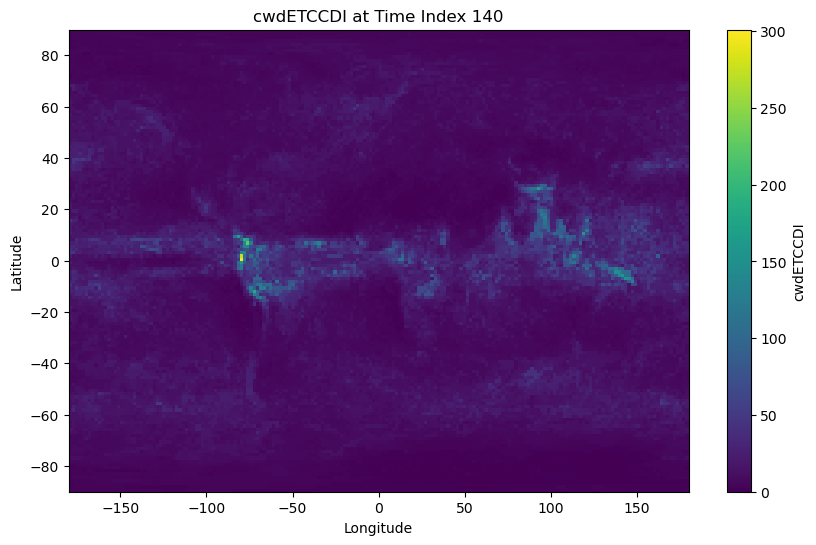

Year: 1990-06-30 12:00:00
GeoTIFF saved at: working_etccdi_file.tif
Resampled GeoTIFF saved at: working_etccdi_file_resampled.tif


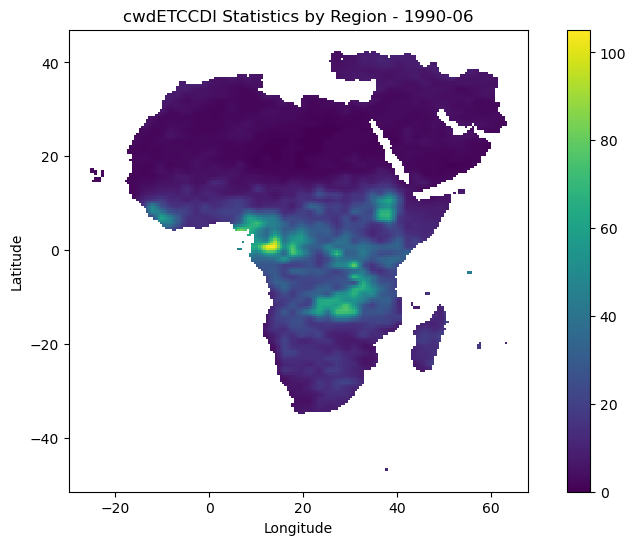

Processing time index: 141


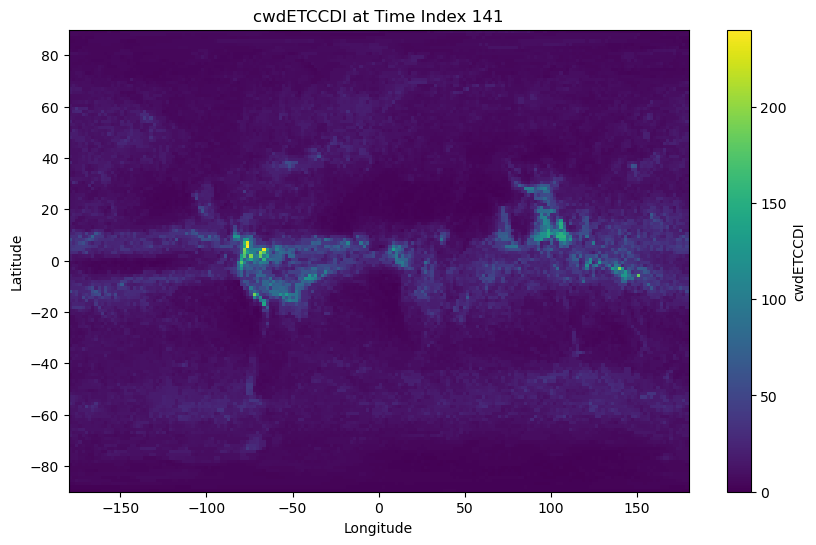

Year: 1991-06-30 12:00:00
GeoTIFF saved at: working_etccdi_file.tif
Resampled GeoTIFF saved at: working_etccdi_file_resampled.tif


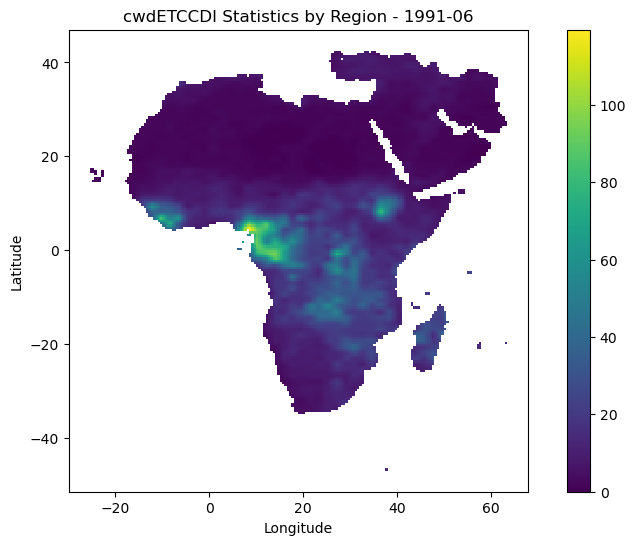

Final DataFrame saved to: etccdi_out_files/cwdETCCDI_1990_06__1991_06.csv


In [24]:
generate_etccdi_temporal_tables(sub_index, etccdi, etccdi_index, '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp')

### Review:

#### Validate completeness of the output index at PG resolution:

Temporally: check that all total number of time periods match
- Spatially: Full extent of PG (for each temporal unit!)

How to do this:

1. Load the 'compiled' etccdi index .csv
2. check for null values

Total length should be: X

check length of temporal units should be: X (dependent on input parameters)
check length of spatial units should be: X

3. Plot the data


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_monthly_average_tx10pETCCDI(dataframe):
    # Group by 'date' and calculate the average 'tx10pETCCDI' for each date
    monthly_avg = dataframe.groupby('date')['tx10pETCCDI'].mean().reset_index()
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['date'], monthly_avg['tx10pETCCDI'], marker='o', linestyle='-')
    plt.title('Average tx10pETCCDI by Year-Month')
    plt.xlabel('Date')
    plt.ylabel('Average tx10pETCCDI')
    plt.grid(True)
    plt.show()

# Assuming your DataFrame is named df


In [ ]:
import geopandas as gpd

# Specify the path to your shapefile or other spatial data file
file_path = '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp'

# Load the data into a GeoDataFrame
gdf = gpd.read_file(file_path)

spatial_extent = len(pd.unique(gdf['gid']))

In [ ]:
validate_etccdi = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/etccdi_out_files/tx10pETCCDI_2015_01__2015_02.csv')
validate_etccdi['date'] = validate_etccdi['year'].astype(str) + '-' + validate_etccdi['month'].astype(str).str.zfill(2)

etccdi_time_length = len(pd.unique(validate_etccdi['date']))
etccdi_spatial_length = len(pd.unique(validate_etccdi['gid']))

#-------------------------------------------------------------------------------------------------------------------------------------------------
# Report null values:

# Specify the columns to check for null values
columns_to_check = ['gid', 'year', 'month', 'date', 'tx10pETCCDI']
print('This prints a summary of Null values:')
# Count null values in the specified columns
null_counts = validate_etccdi[columns_to_check].isnull().sum()
#-------------------------------------------------------------------------------------------------------------------------------------------------
print()
display(null_counts)

print()
print('Summary of temporal and spatial units:')
print()
print(f'This dataset expects to see {time_length} and found {etccdi_time_length}')
print(f'This dataset expects to see {spatial_extent} and found {etccdi_spatial_length}')
print()
print('Average over time to expose any temporal gaps')
#plot_monthly_average_tx10pETCCDI(validate_etccdi)

### Resample to Fine (Granular) Pixel 

Parameters to consider: 
1. What is an appropriate resolution
2. What is the most appropriate resampling method
